In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import pickle
from tqdm import tqdm
import gait_osaka as gait

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
image_vec_shape = 12
gait_key_poses = 16
conditional_vec_shape = 4
pose_image_shape = (160,160,1)
batch_size = 50
full_vec_shape = image_vec_shape+conditional_vec_shape
n_timesteps = 3
angle = '090'

In [4]:
model_OneRNN = keras.models.Sequential()
model_BiRNN = keras.models.Sequential()
model_ConvRNN = keras.models.Sequential()

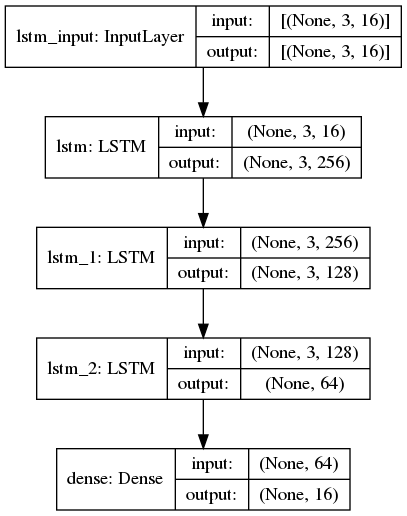

In [5]:
model_OneRNN = keras.models.Sequential()
model_OneRNN.add(keras.layers.LSTM(256,
                                   activation='tanh',
                                   return_sequences=True,
                                   input_shape=(n_timesteps,
                                                image_vec_shape+conditional_vec_shape)
                                  ))
#model_OneRNN.add(keras.layers.LSTM(256,
#                                   activation='tanh',
#                                   return_sequences=True
#                                  ))
model_OneRNN.add(keras.layers.LSTM(128,
                                   activation='tanh',
                                   return_sequences=True
                                  ))
model_OneRNN.add(keras.layers.LSTM(64,
                                   activation='tanh'
                                  ))
model_OneRNN.add(keras.layers.Dense(image_vec_shape+conditional_vec_shape,
                                    activation='linear'
                                  ))
model_OneRNN.compile(optimizer='adam', loss='mse')
plot_model(model_OneRNN, to_file='media/model_OneRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/model_OneRNN_plot.png')
im

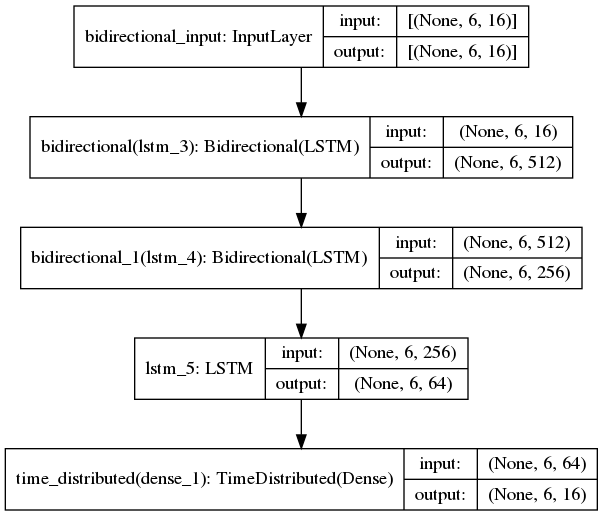

In [6]:
model_BiRNN = keras.models.Sequential()
model_BiRNN.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(256,
                                      activation='tanh',
                                      return_sequences=True),
                                      input_shape=(2*n_timesteps,image_vec_shape+conditional_vec_shape)
                ))
model_BiRNN.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(128,
                                      activation='tanh',
                                      return_sequences=True)
                ))
model_BiRNN.add(keras.layers.LSTM(64,
                                  activation='tanh',
                                  return_sequences=True
                                 ))
model_BiRNN.add(keras.layers.TimeDistributed(
                    keras.layers.Dense(image_vec_shape+conditional_vec_shape)
                ))
model_BiRNN.compile(optimizer='adam', loss='mse')
plot_model(model_BiRNN, to_file='media/model_BiRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/model_BiRNN_plot.png')
im

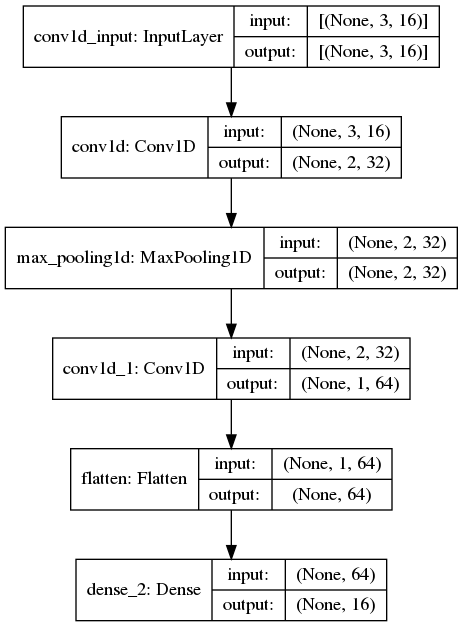

In [7]:
model_ConvRNN = keras.models.Sequential()
model_ConvRNN.add(keras.layers.Conv1D(filters=32,
                                        kernel_size = 2,
                                        activation='tanh',
                                        input_shape=(n_timesteps, image_vec_shape+conditional_vec_shape)
                                     ))
model_ConvRNN.add(keras.layers.MaxPooling1D(pool_size=1))
model_ConvRNN.add(keras.layers.Conv1D(filters=64,
                                      kernel_size= 2,
                                      activation='tanh'))
#model_ConvRNN.add(keras.layers.MaxPooling1D(pool_size=2))
model_ConvRNN.add(keras.layers.Flatten())
model_ConvRNN.add(keras.layers.Dense(image_vec_shape+conditional_vec_shape))
model_ConvRNN.compile(optimizer='adam', loss='mse')
plot_model(model_ConvRNN, to_file='media/model_ConvRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/model_ConvRNN_plot.png')
im

In [8]:
def sampling(args):
    mu, log_var = args
    eps = tf.random.normal(shape=(batch_size, image_vec_shape), mean=0., stddev=1.0)
    return mu + tf.math.exp(log_var/2.)*eps
def encoder_model():
    x_in = keras.layers.Input(name="x_image",
                              shape=pose_image_shape)
    condition_in = keras.layers.Input(name="condition_hotshot",
                                      shape=(gait_key_poses,))
    condi_vec1 = keras.layers.Dense(8,activation='relu',name="condition_dense_1")(condition_in)
    condi_vec = keras.layers.Dense(4,activation='relu',name="condition_dense_2")(condi_vec1)
    x = keras.layers.Conv2D(filters=16,
                            kernel_size=(5,5),
                            strides=(3,3),
                            activation='relu',
                            name="x_conv_1")(x_in)
    x = keras.layers.BatchNormalization(name="x_batch_norm_1")(x,training=True)
    x = keras.layers.Conv2D(filters=32,
                            kernel_size=(5,5),
                            strides=(3,3),
                            activation='relu',
                            name="x_conv_2")(x)
    x = keras.layers.BatchNormalization(name="x_batch_norm_2")(x, training=True)
    x = keras.layers.Conv2D(filters=64,
                            kernel_size=(5,5),
                            strides=(3,3),
                            activation='relu',
                            name='x_conv_3')(x)
    x = keras.layers.BatchNormalization(name="x_batch_norm_3")(x, training=True)
    x = keras.layers.Flatten(name="x_flatten")(x)
    x = keras.layers.Dense(336, activation='relu',name="x_dense_final")(x)
    x_vec = keras.layers.concatenate([x,condi_vec], name="concat_xvec")
    x_vec = keras.layers.Dense(32, activation='relu',name="xvec_dense_final")(x_vec)
    mu = keras.layers.Dense(image_vec_shape, activation='linear',name="mu_dense")(x_vec)
    log_var = keras.layers.Dense(image_vec_shape, activation='linear', name="logvar_dense")(x_vec)
    z = keras.layers.Lambda(sampling, output_shape=(image_vec_shape,), name="lambda_sampling")([mu,log_var])
    z_cond = keras.layers.concatenate([z, condi_vec],name="concat_zcond")
    
    encoder = keras.Model([x_in,condition_in], z_cond)
    
    z1 = keras.layers.Dense(32, activation='relu', name="z_dense_1")(z_cond)
    z1 = keras.layers.Dense(336, activation='relu', name="z_dense_2")(z1)
    z1 = keras.layers.Dense(1024, activation='relu', name="z_dense_3")(z1)
    zim = keras.layers.Reshape((4,4,64),name="reshape_image")(z1)
    zim = keras.layers.Conv2DTranspose(filters=32,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu',
                                       name="z_convT_1")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_1")(zim, training=True)
    zim = keras.layers.Conv2DTranspose(filters=16,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu',
                                       name="z_convT_2")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_2")(zim, training=True)
    zim = keras.layers.Conv2DTranspose(filters=8,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu',
                                       name="z_convT_3")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_3")(zim, training=True)
    y = keras.layers.Conv2D(filters=1,
                            kernel_size=(1,1),
                            activation='tanh',
                            name="image_out")(zim)
    
    #decoder = keras.models.Model(z_cond_in, y)
    full_model = keras.Model([x_in, condition_in], y)
    
    reconstruction_loss = tf.math.reduce_sum(tf.math.reduce_sum(keras.losses.binary_crossentropy(x_in, y), axis=1),axis=1)
    kl_loss = 0.5*tf.math.reduce_sum(tf.math.square(mu) + tf.math.exp(log_var) - log_var - 1, axis=-1)
    cvae_loss = reconstruction_loss + kl_loss
    
    
    
    #full_model.add_loss(cvae_loss)
    full_model.compile(optimizer='adam', loss = lambda : cvae_loss)
    ## Ignore the missing from loss dictionary error
    return encoder, full_model
CVAE, CVAE_FULL = encoder_model()

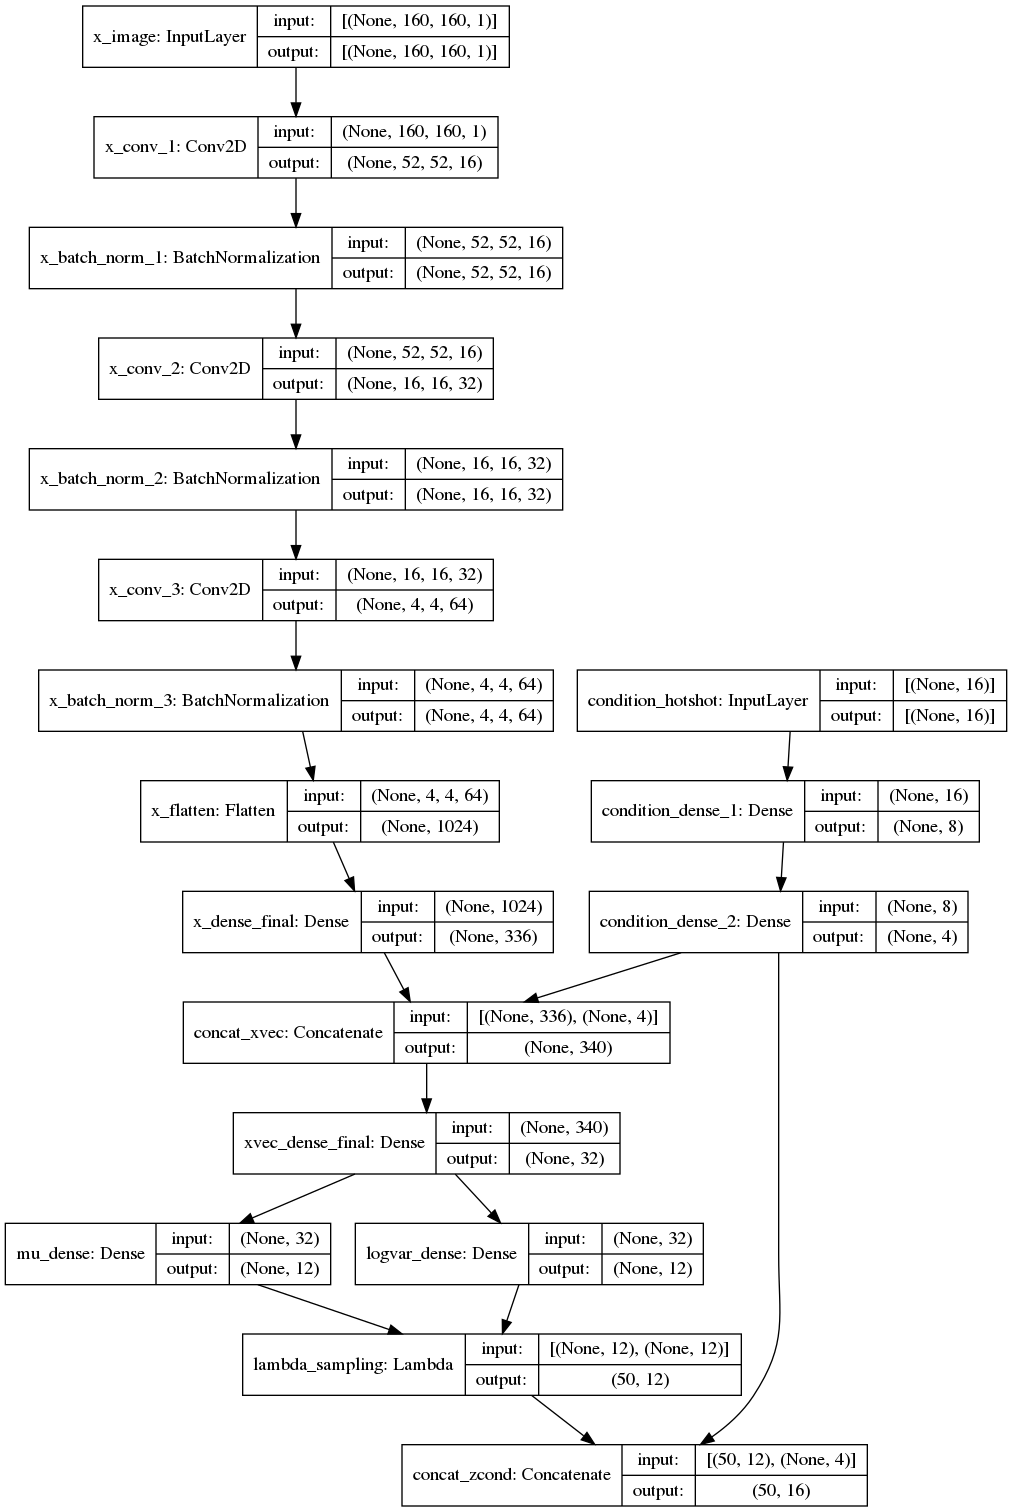

In [9]:
plot_model(CVAE, to_file='media/CVAE.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/CVAE.png')
im

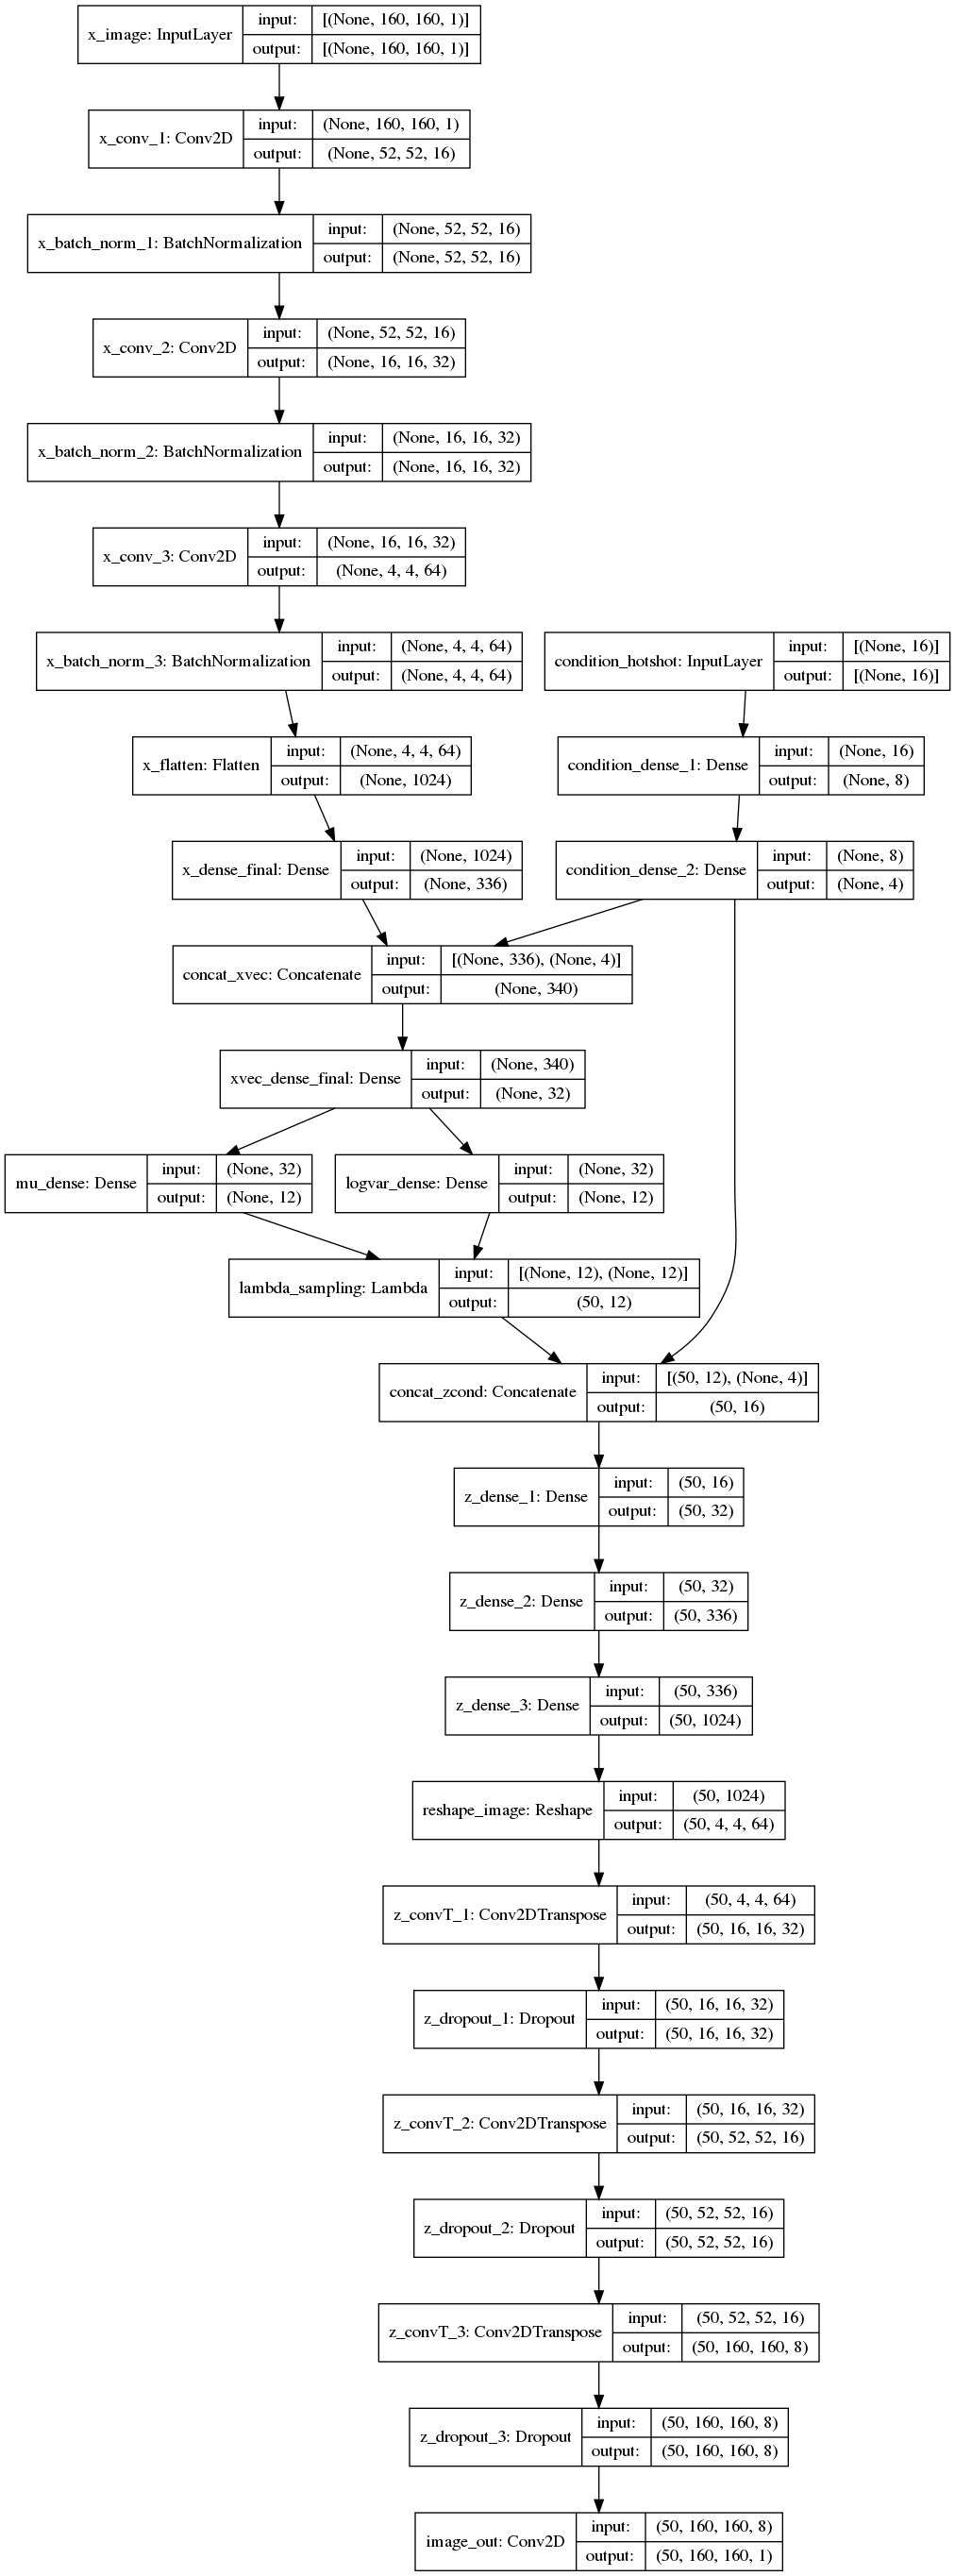

In [10]:
plot_model(CVAE_FULL, to_file='media/CVAE_FULL.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/CVAE_FULL.png')
im

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, files, labels, preprocess=None, batch_size = 50, dim=(160,160), n_channels=1, n_classes=16, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.files = files
        self.preprocess = preprocess or (lambda x : x)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        files_temp = [self.files[k] for k in indexes]
        
        X,z = self.__data_generation(files_temp)
        return [X,z], None
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, files_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        z = np.empty((self.batch_size),dtype=int)
        for i,file in enumerate(files_temp):
            X[i,] = cv2.copyMakeBorder(self.preprocess(cv2.imread(file)), 0, 0, 20, 20, cv2.BORDER_CONSTANT, (0,0,0)).reshape(*self.dim, self.n_channels)/255.
            z[i] = self.labels[file]
        return X, keras.utils.to_categorical(z, num_classes=self.n_classes)

In [12]:
labels = gait.fetch_labels(label_angle=angle,save=False,override=True)

100%|██████████| 34/34 [00:00<00:00, 62.73it/s]


In [13]:
files = [filename for filename in labels]

In [14]:
test_files = []
test_partition = np.random.randint(0,len(files),size=3000)
for i in test_partition:
    test_files.append(files[i])
for i in sorted(test_partition)[::-1]:
    del files[i]

In [15]:
train_data = DataGenerator(files,labels,preprocess=gait.preprocess)
valid_data = DataGenerator(test_files, labels, preprocess=gait.preprocess)

In [16]:
'''history = CVAE_FULL.fit_generator(generator=train_data,
                                  validation_data = valid_data,
                                  steps_per_epoch = len(files)//batch_size,
                                  epochs=1,
                                  validation_steps = len(test_files)//batch_size,
                                  use_multiprocessing=True) #,
#                        workers=6)
'''

'history = CVAE_FULL.fit_generator(generator=train_data,\n                                  validation_data = valid_data,\n                                  steps_per_epoch = len(files)//batch_size,\n                                  epochs=1,\n                                  validation_steps = len(test_files)//batch_size,\n                                  use_multiprocessing=True) #,\n#                        workers=6)\n'

In [17]:
len(files)

196920

In [18]:
CVAE_FULL.load_weights('weights/CVAE_FULL.h5')

In [19]:
#CVAE_FULL.save("weights/CVAE_FULL.h5")

In [27]:
imgs = np.empty((50,160,160,1))
z = np.empty((50),dtype=int)
for i,file in enumerate(files[120:170]):
    imgs[i,] = cv2.copyMakeBorder(gait.preprocess(cv2.imread(file)), 0, 0, 20, 20, cv2.BORDER_CONSTANT, (0,0,0)).reshape(160,160,1)/255.
    z[i] = labels[file]
z_vec = keras.utils.to_categorical(z, num_classes=16)
img_predict = CVAE_FULL.predict([imgs,z_vec],batch_size=50)

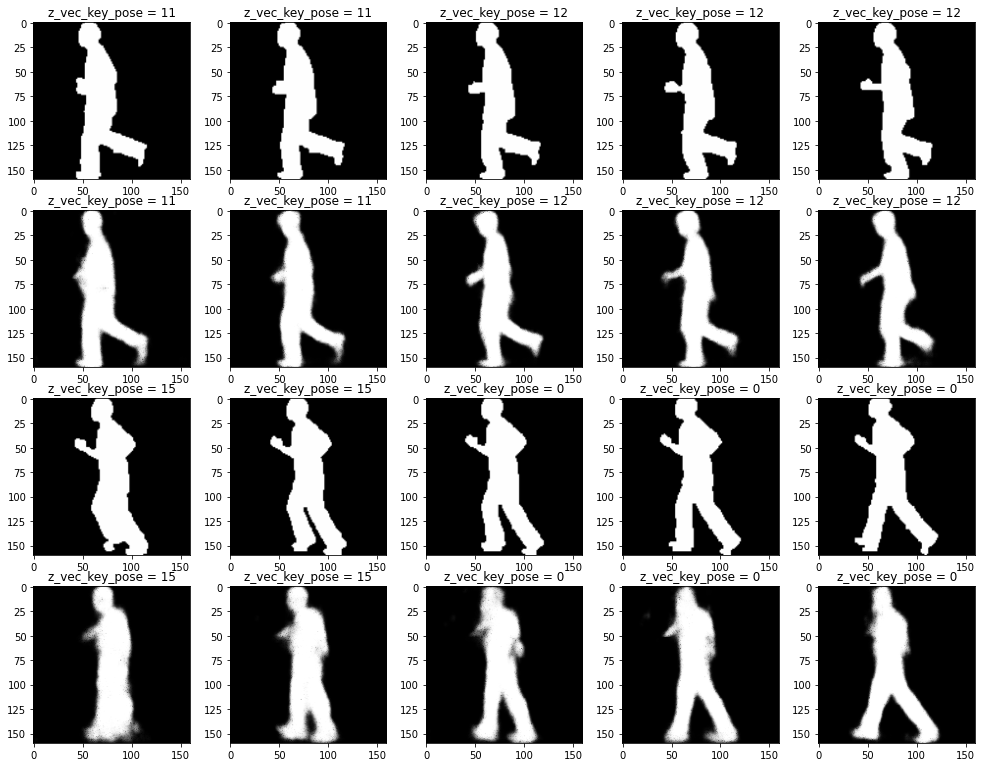

In [28]:
cols = 5
rows = 10
fig = plt.figure(figsize=(17,34))
cnt = 0
for i in range(1 , 21):
    
    ax = fig.add_subplot(rows, cols, i)
    if ((i-1)//5)%2==0:
        ax.set_title('z_vec_key_pose = '+str(z[i-1]))
        plt.imshow(imgs[i+30],cmap='gray')
    else:
        ax.set_title('z_vec_key_pose = '+str(z[i-6]))
        plt.imshow(img_predict[i+25],cmap='gray')
#plt.savefig("AutoEncoders.jpg")
plt.show()

In [30]:
## Have to train on a bigger dataset

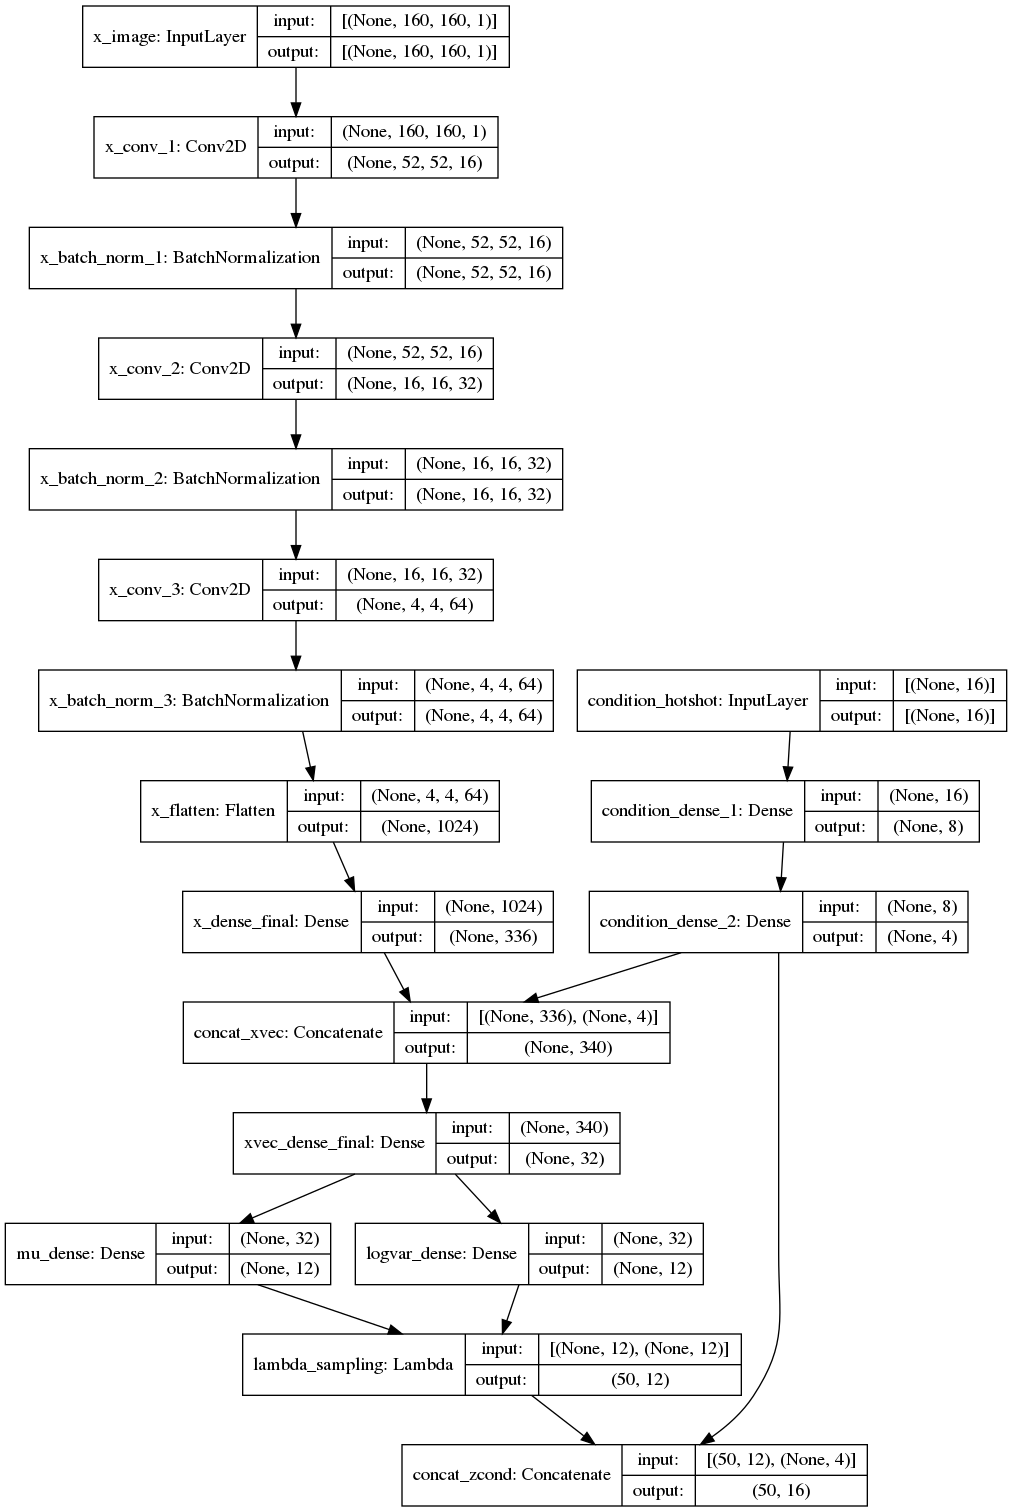

In [29]:
encoder = keras.models.Model(CVAE_FULL.input, CVAE_FULL.get_layer("concat_zcond").output)
plot_model(encoder, to_file='media/encoder.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/encoder.png')
im

In [50]:
encoded_vec = gait.encode_data(encoder,label_angle='090',override=True)

100%|██████████| 34/34 [04:03<00:00,  7.16s/it]


In [51]:
# enc_vec = encoder.predict([imgs,z_vec],batch_size=50)

In [52]:
encoded_vec['/home/hexplex0xff/GAN/TreadmillDatasetA/00001/gallery_10km'].shape

(300, 16)

In [53]:
sum([arr.shape[0]-3 for key,arr in encoded_vec.items()])

198084

In [54]:
1236*50/4

15450.0

In [55]:
import matplotlib.pyplot as plt

In [56]:
x, y = gait.encoded2timeseries(encoded_vec,3)

In [57]:
class ImageNoise(keras.utils.Sequence):
    def __init__(self, encodedVec, processTimeseries, timesteps=6, batch_size = 50, n_classes=16, occlusionRatio=0.08, shuffle=True):
        self.encodedData ,_ = processTimeseries(encodedVec, timesteps, y_out = False)
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.occlusionRatio = occlusionRatio
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.encodedData)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.addNoise(self.encodedData[indexes].copy(), self.occlusionRatio)
        Y = self.encodedData[indexes].copy()
        
        return X,Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.encodedData))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def addNoise(self, arr, ratio=0.07):
        """
            ratio percent of images are occluded
        """
        return (np.random.random(arr.shape[:2])>ratio).reshape(*arr.shape[:2],1)*arr

In [99]:
#history = model_OneRNN.fit(x,y,epochs=200, validation_split=0.1,batch_size=64)

Train on 62604 samples, validate on 6956 samples
Epoch 1/200
62604/62604 [==============================] - 26s - loss: 0.4158 - val_loss: 0.2769
Epoch 2/200
62604/62604 [==============================] - 24s - loss: 0.3166 - val_loss: 0.2687
Epoch 3/200
62604/62604 [==============================] - 23s - loss: 0.3021 - val_loss: 0.2681
Epoch 4/200
62604/62604 [==============================] - 23s - loss: 0.2910 - val_loss: 0.2659
Epoch 5/200
62604/62604 [==============================] - 23s - loss: 0.2798 - val_loss: 0.2643
Epoch 6/200
62604/62604 [==============================] - 23s - loss: 0.2685 - val_loss: 0.2626
Epoch 7/200
62604/62604 [==============================] - 23s - loss: 0.2563 - val_loss: 0.2664
Epoch 8/200
62604/62604 [==============================] - 23s - loss: 0.2442 - val_loss: 0.2699
Epoch 9/200
62604/62604 [==============================] - 24s - loss: 0.2315 - val_loss: 0.2693
Epoch 10/200
62604/62604 [==============================] - 24s - loss: 0.2192

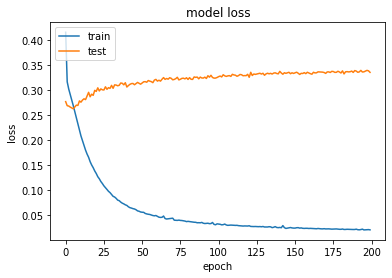

In [100]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [101]:
#model_OneRNN.save("weights/OneRNN.h5")

In [42]:
model_OneRNN.load_weights("weights/OneRNN.h5")

In [58]:
train_vec = { ele:encoded_vec[ele] for ele in list(encoded_vec.keys())[:-100] }
valid_vec = { ele:encoded_vec[ele] for ele in list(encoded_vec.keys())[-100:] }

In [59]:
train_data = ImageNoise(train_vec,gait.encoded2timeseries,occlusionRatio=0.1)
valid_data = ImageNoise(valid_vec,gait.encoded2timeseries,occlusionRatio=0.1)

In [114]:
# history = model_BiRNN.fit(train_data, 
#                           validation_data = valid_data, 
#                           epochs=200)

Epoch 1/200
1208/1208 [==============================] - 24s 16ms/step - loss: 0.1903 - val_loss: 0.0266
Epoch 2/200
1208/1208 [==============================] - 18s 15ms/step - loss: 0.0324 - val_loss: 0.0173
Epoch 3/200
1208/1208 [==============================] - 18s 15ms/step - loss: 0.0236 - val_loss: 0.0158
Epoch 4/200
1208/1208 [==============================] - 18s 15ms/step - loss: 0.0211 - val_loss: 0.0143
Epoch 5/200
1208/1208 [==============================] - 18s 15ms/step - loss: 0.0204 - val_loss: 0.0137
Epoch 6/200
1208/1208 [==============================] - 18s 15ms/step - loss: 0.0193 - val_loss: 0.0161
Epoch 7/200
1208/1208 [==============================] - 18s 15ms/step - loss: 0.0202 - val_loss: 0.0146
Epoch 8/200
1208/1208 [==============================] - 17s 14ms/step - loss: 0.0182 - val_loss: 0.0136
Epoch 9/200
1208/1208 [==============================] - 17s 14ms/step - loss: 0.0177 - val_loss: 0.0130
Epoch 10/200
1208/1208 [==============================]

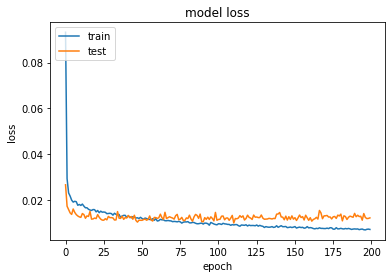

In [117]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [116]:
#model_BiRNN.save("weights/BiRNN.h5")

In [43]:
model_BiRNN.load_weights('weights/BiRNN.h5')

In [44]:
def partial_decoder(cvae_full):
    layers = [
        cvae_full.get_layer("z_dense_1"),
        cvae_full.get_layer("z_dense_2"),
        cvae_full.get_layer("z_dense_3"),
        cvae_full.get_layer("reshape_image"),
        cvae_full.get_layer("z_convT_1"),
        cvae_full.get_layer("z_dropout_1"),
        cvae_full.get_layer("z_convT_2"),
        cvae_full.get_layer("z_dropout_2"),
        cvae_full.get_layer("z_convT_3"),
        cvae_full.get_layer("z_dropout_3"),
        cvae_full.get_layer("image_out")
    ]
    z_vec = keras.layers.Input(name="z_cond",
                              shape=(image_vec_shape+conditional_vec_shape,))
    x = None
    for layer in layers:
        if x is None:
            x = layer(z_vec)
        else:
            x = layer(x)
    return keras.models.Model(z_vec, x)

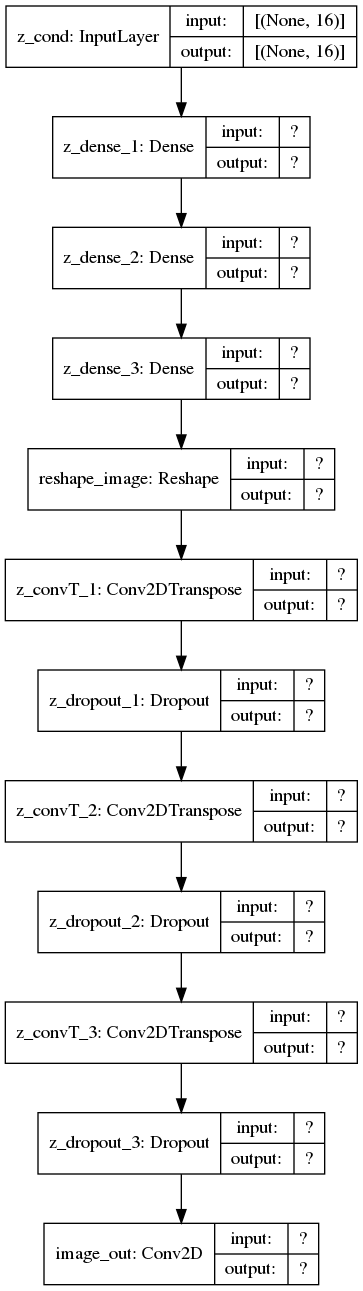

In [45]:
decoder = partial_decoder(CVAE_FULL)
plot_model(decoder, to_file='media/decoder.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/decoder.png')
im

In [46]:
imgs = np.empty((50,160,160,1))
z = np.empty((50),dtype=int)
for i,file in enumerate(files[150:200]):
    imgs[i,] = cv2.copyMakeBorder(gait.preprocess(cv2.imread(file)), 0, 0, 20, 20, cv2.BORDER_CONSTANT, (0,0,0)).reshape(160,160,1)/255.
    z[i] = labels[file]
z_vec = keras.utils.to_categorical(z, num_classes=16)
encoded_vec = encoder.predict([imgs,z_vec],batch_size=50)
out = []
for i in range(len(encoded_vec)-4):
    al= imgs[i:i+4,:,:,:]
    nex_enc = model_OneRNN.predict(np.expand_dims(encoded_vec[i:i+3,:],axis=0))
    img_out = decoder.predict(nex_enc.reshape(1,-1))
    al = np.append(al,img_out,axis=0)
    out.append(np.array(al))

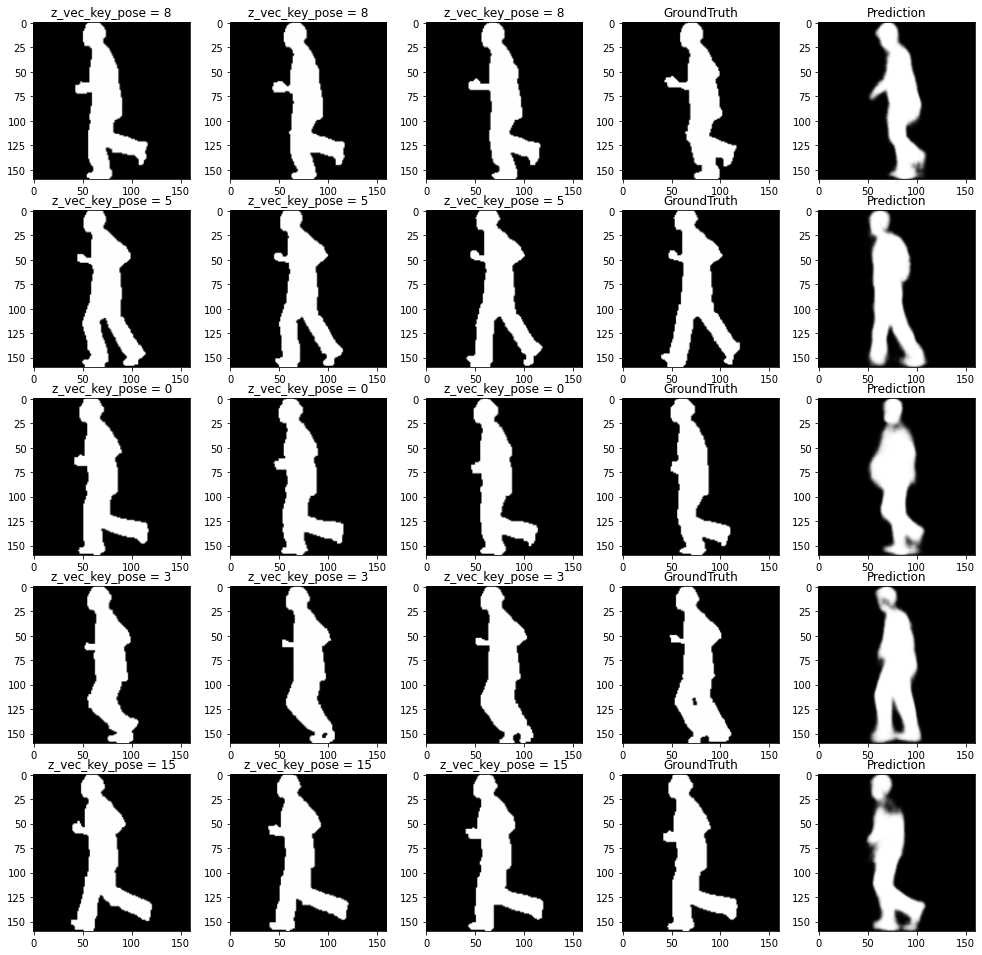

In [47]:
indices = np.random.randint(0,len(encoded_vec)-4,5)
cols = 5
rows = 10
fig = plt.figure(figsize=(17,34))
cnt = 0
for i, index in enumerate(indices):
    for j in range(5):
    
        ax = fig.add_subplot(rows, cols, 5*i + j + 1)
        if j == 4:
            ax.set_title('Prediction')
        elif j == 3:
            ax.set_title('GroundTruth')
        else:
            ax.set_title('z_vec_key_pose = '+str(z[index]))
        plt.imshow(out[index][j,:,:,:],cmap='gray')


#plt.savefig("TimeSeries.jpg")
plt.show()

## BiRNN output

In [60]:
imgs = np.empty((50,160,160,1))
grnd = np.empty((50,160,160,1))
z = np.empty((50),dtype=int)
occlu = 0.5
for i,file in enumerate(files[150:200]):
    imgs[i,] = cv2.copyMakeBorder(gait.preprocess(cv2.imread(file)), 0, 0, 20, 20, cv2.BORDER_CONSTANT, (0,0,0)).reshape(160,160,1)/255.
    z[i] = labels[file]
z_vec = keras.utils.to_categorical(z, num_classes=16)
encoded_vec = encoder.predict([imgs,z_vec],batch_size=50)
out = []
mask = train_data.addNoise(np.ones_like(np.expand_dims(encoded_vec, axis=0)),occlu)[0]
for i in range(len(encoded_vec)-6):
    grnd = imgs[i:i+6,:,:,:]
    al = mask[i:i+6,0].reshape(6,1,1,1)*grnd
    filter_enc = model_BiRNN.predict(mask[i:i+6,0].reshape(1,6,1)*np.expand_dims(encoded_vec[i:i+6,:],axis=0))
    imgs_out = decoder.predict(filter_enc.reshape(6,16))
    al = np.array([al, imgs_out, grnd])
    out.append(np.array(al))

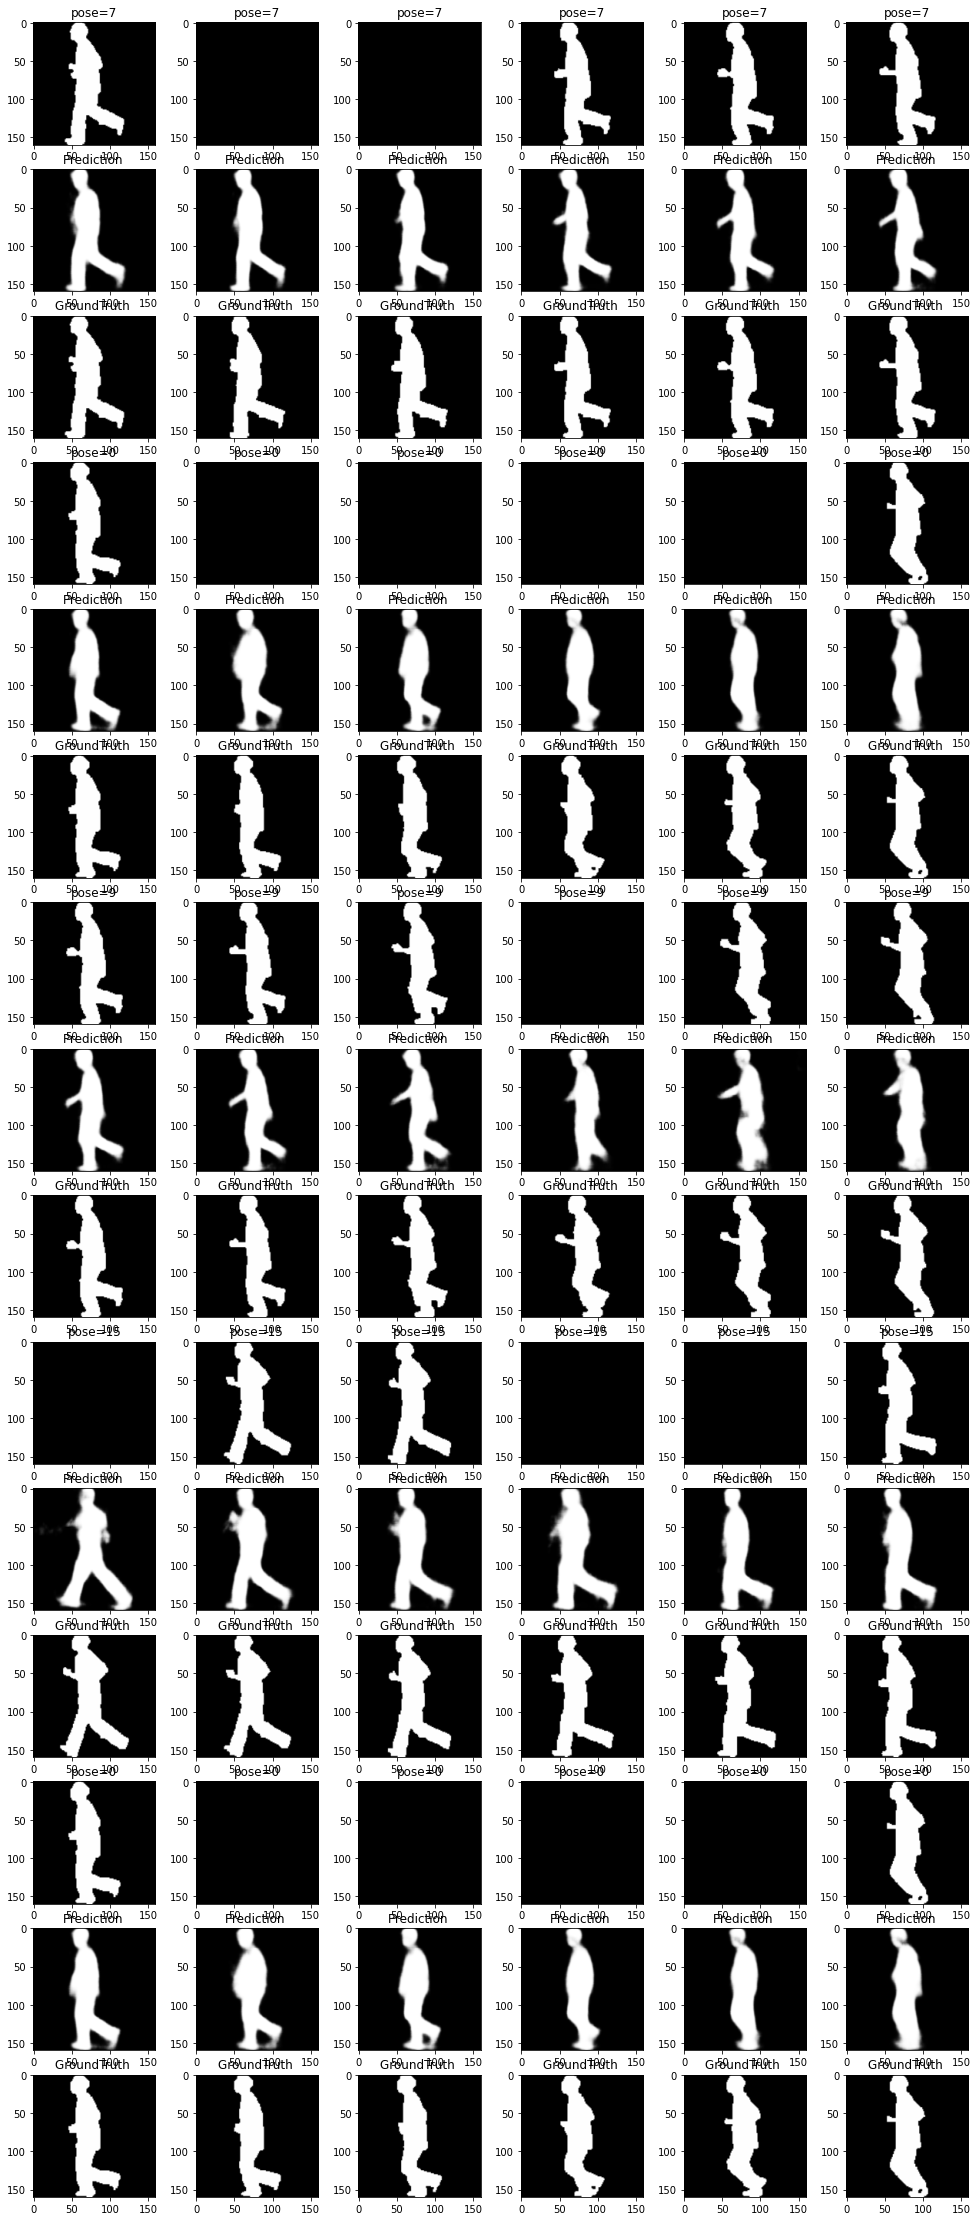

In [61]:
indices = np.random.randint(0,len(encoded_vec)-6,5)
cols = 6
rows = 15
fig = plt.figure(figsize=(17,40))
cnt = 0
for i, index in enumerate(indices):
    for j in range(cols):
        for k in range(3):
            ax = fig.add_subplot(rows, cols, cols*(3*i+k) + j + 1)
            inf = ''
            if k == 1:
                inf += 'Prediction '
            elif k == 2:
                inf += 'GroundTruth '
            else:
                inf +='pose='+str(z[index])
            ax.set_title(inf)    
            plt.imshow(out[index][k,j,:,:,:],cmap='gray')


#plt.savefig("TimeSeries_BI.jpg")
plt.show()

In [ ]:
## The results are very bad